# Implementación de Modelo de Regresión Lineal con Validación Cruzada

Este cuaderno muestra la implementación de un modelo de regresión lineal simple utilizando validación cruzada para seleccionar los mejores parámetros del modelo. Luego, el modelo se prueba en un conjunto de datos no visto (conjunto de prueba).

## 1. Carga de Librerías 
En esta primera sección, cargamos todas las librerías necesarias para llevar a cabo el análisis.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold

## 2. División del Conjunto de Datos en Entrenamiento y Prueba

En esta etapa, dividimos el conjunto de datos en dos partes: uno para el entrenamiento y otro para la prueba. El conjunto de entrenamiento se utilizará para ajustar el modelo, mientras que el conjunto de prueba se utilizará para evaluar el rendimiento del modelo al final del proceso.

Utilizamos `train_test_split` para realizar esta división, separando el 70% de los datos para el entrenamiento y el 30% restante para la prueba.


In [3]:
#Lectura de datos
df = pd.read_csv('BillFlipper.csv')

X = np.array(df['bill_length_mm'])
y = np.array(df['flipper_length_mm'])
specie = np.array(df['species_Adelie'])

# Dividimos los datos en entrenamiento y prueba
x_train, x_test, y_train, y_test, specie_train, specie_test = train_test_split(X, y, specie, test_size=0.3, random_state=42)


## 3. Validación Cruzada

La validación cruzada es una técnica utilizada para evaluar el rendimiento de un modelo y ajustar sus hiperparámetros. En este cuaderno, utilizamos `KFold` para realizar una validación cruzada de 5 pliegues. Esto significa que el conjunto de entrenamiento se divide en 5 subconjuntos, donde en cada iteración 4 se utilizan para entrenar y 1 para validar.

El modelo se entrena en cada pliegue, y se evalúa su rendimiento utilizando la métrica F1-Score. Finalmente, seleccionamos los mejores parámetros basándonos en el mejor F1-Score obtenido durante la validación.


In [5]:
# Parámetros iniciales
alpha = 0.001  # Tasa de aprendizaje
epochs = 10000  # Número máximo de iteraciones
tolerance = 1e-6  # Tolerancia para la convergencia
kfolds = 5  # Número de pliegues para la validación cruzada

kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)
best_m, best_b = None, None
best_f1 = -np.inf

# Validación cruzada
for fold, (train_index, val_index) in enumerate(kf.split(x_train)):
    print(f"Validación cruzada - Pliegue {fold + 1}/{kfolds}")

    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    specie_train_fold, specie_val_fold = specie_train[train_index], specie_train[val_index]

    m, b = 0, 0  # Reiniciar los parámetros para cada pliegue
    n_train_fold = len(X_train_fold)

    for epoch in range(epochs):
        hxi = m * X_train_fold + b
        error = hxi - y_train_fold
        costo_m = (1 / n_train_fold) * sum(error * X_train_fold)
        costo_b = (1 / n_train_fold) * sum(error)
        m -= alpha * costo_m
        b -= alpha * costo_b

        if abs(alpha * costo_m) < tolerance and abs(alpha * costo_b) < tolerance:
            print("La convergencia ha sido alcanzada en el pliegue.")
            break

    # Evaluar en el conjunto de validación
    predicciones_val = m * X_val_fold + b
    clasificacion_specie_val = np.where(y_val_fold > predicciones_val, 1, 0)
    f1 = f1_score(specie_val_fold, clasificacion_specie_val, pos_label=1)

    print(f"F1 Score en el pliegue {fold + 1}: {f1:.2f}")

    if f1 > best_f1:
        best_f1 = f1
        best_m, best_b = m, b

print(f"Mejor F1 Score obtenido durante la validación cruzada: {best_f1:.2f}")
print(f"Mejor Pendiente (m): {best_m}")
print(f"Mejor Intercepción (b): {best_b}")


Validación cruzada - Pliegue 1/5
F1 Score en el pliegue 1: 0.68
Validación cruzada - Pliegue 2/5
F1 Score en el pliegue 2: 0.65
Validación cruzada - Pliegue 3/5
F1 Score en el pliegue 3: 0.89
Validación cruzada - Pliegue 4/5
F1 Score en el pliegue 4: 0.77
Validación cruzada - Pliegue 5/5
F1 Score en el pliegue 5: 0.60
Mejor F1 Score obtenido durante la validación cruzada: 0.89
Mejor Pendiente (m): 4.15268110336043
Mejor Intercepción (b): 16.68170524398098


## 4. Evaluación en el Conjunto de Prueba

Después de seleccionar el mejor modelo basado en la validación cruzada, lo evaluamos en el conjunto de prueba, que no ha sido utilizado en las etapas anteriores. 

Se generan predicciones utilizando los mejores parámetros encontrados, y se calculan las métricas de evaluación como la precisión, el recall y el F1-Score. También se genera una matriz de confusión para visualizar el rendimiento del modelo.


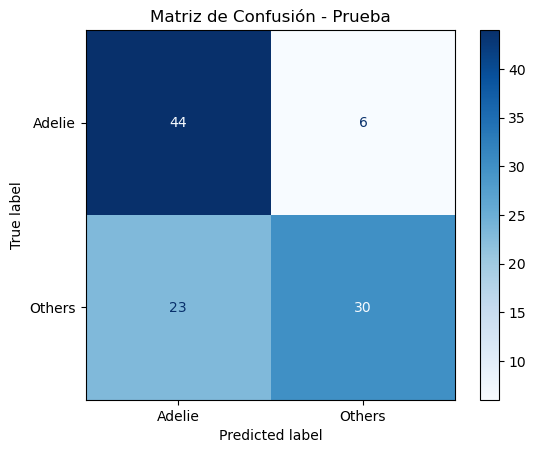

Precisión: 0.66
Recall: 0.88
F1 Score: 0.75


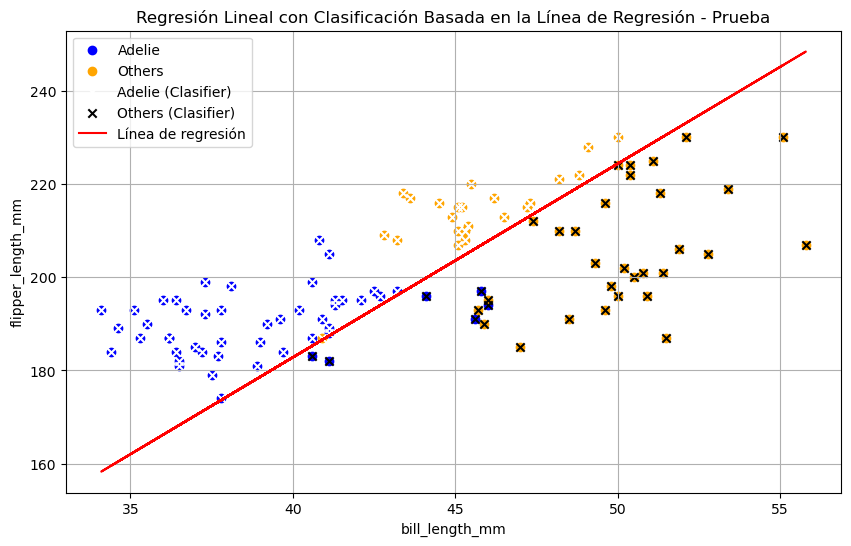

In [7]:
# RESULTADOS DE PRUEBA utilizando los mejores parámetros
predicciones_test = best_m * x_test + best_b
clasificacion_specie_test = np.where(y_test > predicciones_test, 1, 0)

# Generar la matriz de confusión para los datos de prueba
cm_test = confusion_matrix(specie_test, clasificacion_specie_test, labels=[1, 0])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Adelie', 'Others'])

# Mostrar la matriz de confusión visualmente para los datos de prueba
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Prueba")
plt.show()

# Calcular precisión, recall y F1-score para la clasificación basada en la línea de regresión en el conjunto de prueba
precision = precision_score(specie_test, clasificacion_specie_test, pos_label=1)
recall = recall_score(specie_test, clasificacion_specie_test, pos_label=1)
f1 = f1_score(specie_test, clasificacion_specie_test, pos_label=1)

# Mostrar los resultados de las métricas de evaluación en el conjunto de prueba
print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Graficar los puntos de datos junto con la línea de regresión
plt.figure(figsize=(10, 6))

# Puntos de datos clasificados originalmente como Adelie (azul) y otros (naranja)
plt.scatter(x_test[specie_test == 1], y_test[specie_test == 1], color='blue', label='Adelie')
plt.scatter(x_test[specie_test == 0], y_test[specie_test == 0], color='orange', label='Others')

# Puntos de datos clasificados según la nueva clasificación basada en la línea de regresión
plt.scatter(x_test[clasificacion_specie_test == 1], y_test[clasificacion_specie_test == 1], color='white', marker='x', label='Adelie (Clasifier)')
plt.scatter(x_test[clasificacion_specie_test == 0], y_test[clasificacion_specie_test == 0], color='black', marker='x', label='Others (Clasifier)')

# Línea de regresión ajustada
plt.plot(x_test, predicciones_test, color='red', label='Línea de regresión')

# Etiquetas y título del gráfico
plt.xlabel('bill_length_mm')
plt.ylabel('flipper_length_mm')
plt.title('Regresión Lineal con Clasificación Basada en la Línea de Regresión - Prueba')
plt.legend()
plt.grid(True)
plt.show()
